# Huấn luyện các mô hình Machine Learning cổ điển (Baseline)

**Mục tiêu**: Sử dụng bộ đặc trưng Scattering Transform đã được trích xuất để huấn luyện và so sánh hiệu suất của các mô hình ML cổ điển, bao gồm Random Forest, XGBoost, và SVM.

**Quy trình**: 
1. **Tải dữ liệu**: Tải bộ đặc trưng Scattering đã được cân bằng.
2. **Phân chia Train/Test (80/20)**: Chia dữ liệu thành một tập training lớn (`_base`) và một tập test cuối cùng (`_final`) để đánh giá khách quan.
3. **Cross-Validation (3-fold)**: Thực hiện 3-fold cross-validation trên tập `_base` để so sánh và lựa chọn mô hình tốt nhất.
4. **Đánh giá cuối cùng**: Huấn luyện mô hình tốt nhất trên toàn bộ tập `_base` và đánh giá hiệu suất trên tập `_final`.

In [1]:
# Cell 1: Imports

# Thư viện xử lý dữ liệu
import numpy as np
import os
import time
import pandas as pd

# Các mô hình từ scikit-learn và XGBoost
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Các công cụ đánh giá và Cross-Validation
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Cài đặt style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [2]:
# Cell 2: Tải dữ liệu và Tách Train/Test Lần Đầu

PROCESSED_DATA_DIR = '../data/processed/'

# Tải toàn bộ dữ liệu đã cân bằng
print("Đang tải dữ liệu đặc trưng Scattering...")
X_data = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_scattering_balanced.npz'))
X = X_data['features']
y = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_labels_balanced.npy'))

print(f"Đã tải thành công bộ dữ liệu đầy đủ với {X.shape[0]} mẫu.")

# Tách dữ liệu thành tập training lớn (base) và tập test cuối cùng (final)
# Sử dụng stratify=y để đảm bảo tỷ lệ các lớp được giữ nguyên trong cả hai tập
X_train_base, X_test_final, y_train_base, y_test_final = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Đã chia dữ liệu thành công:")
print(f"- Tập Training Base: {X_train_base.shape[0]} mẫu ({len(X_train_base)/len(X)*100:.1f}%)")
print(f"- Tập Test Final:   {X_test_final.shape[0]} mẫu ({len(X_test_final)/len(X)*100:.1f}%)")

Đang tải dữ liệu đặc trưng Scattering...
Đã tải thành công bộ dữ liệu đầy đủ với 20534 mẫu.
Đã chia dữ liệu thành công:
- Tập Training Base: 16427 mẫu (80.0%)
- Tập Test Final:   4107 mẫu (20.0%)


In [4]:
# Cell 3: Thực hiện 3-fold Cross-Validation trên tập Training Base

# Định nghĩa các mô hình baseline để so sánh
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM (Linear)": SVC(kernel='linear', probability=True, random_state=42) 
}

# Thiết lập chiến lược 3-fold Stratified Cross-Validation
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

print("Bắt đầu quá trình Cross-Validation trên tập Training Base...")

for model_name, model in models.items():
    print(f"--- Đang đánh giá {model_name}...")
    start_time = time.time()
    
    # Sử dụng cross_val_score để tính accuracy trung bình qua 3 folds
    scores = cross_val_score(model, X_train_base, y_train_base, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
    
    end_time = time.time()
    
    # Lưu kết quả
    results.append({
        'model': model_name,
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std(),
        'cv_time': end_time - start_time
    })
    print(f"Hoàn thành trong {end_time - start_time:.2f} giây.")

# Chuyển kết quả thành DataFrame để dễ xem
results_df = pd.DataFrame(results).sort_values(by='mean_accuracy', ascending=False)

print("=== KẾT QUẢ CROSS-VALIDATION ===")
print(results_df)

C:\Users\Nguyen duc phat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Bắt đầu quá trình Cross-Validation trên tập Training Base...
--- Đang đánh giá Random Forest...
Hoàn thành trong 285.45 giây.
--- Đang đánh giá XGBoost...


C:\Users\Nguyen duc phat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Hoàn thành trong 1432.48 giây.
--- Đang đánh giá SVM (Linear)...
Hoàn thành trong 11991.80 giây.
=== KẾT QUẢ CROSS-VALIDATION ===
           model  mean_accuracy  std_accuracy       cv_time
1        XGBoost       0.751872      0.001952   1432.484438
0  Random Forest       0.747732      0.002133    285.451737
2   SVM (Linear)       0.739453      0.002489  11991.802468


Mô hình tốt nhất được chọn: XGBoost
Đang huấn luyện lại mô hình XGBoost trên toàn bộ 16427 mẫu training...
Hoàn thành huấn luyện trong 325.17 giây.
--- ĐÁNH GIÁ CUỐI CÙNG TRÊN 4107 MẪU TEST FINAL ---
              precision    recall  f1-score   support

      Absent       0.73      0.76      0.74      2000
     Present       0.76      0.73      0.74      2107

    accuracy                           0.74      4107
   macro avg       0.74      0.74      0.74      4107
weighted avg       0.75      0.74      0.74      4107



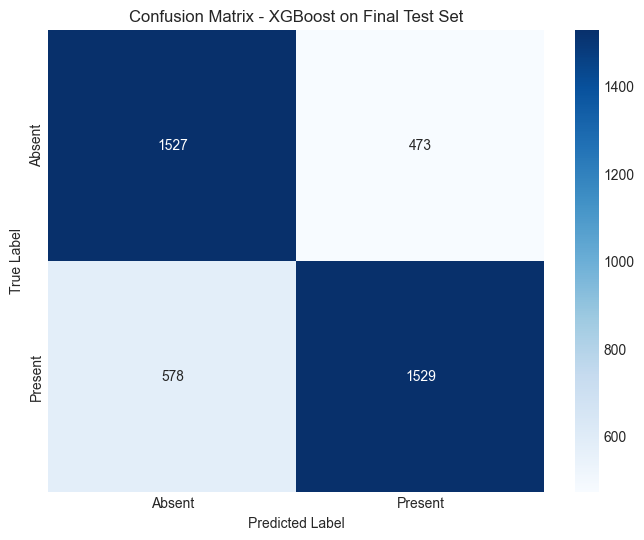

In [6]:
# Cell 4: Huấn luyện và Đánh giá Cuối Cùng trên Tập Test Final

# Chọn mô hình tốt nhất dựa trên mean_accuracy từ CV
best_model_name = results_df.iloc[0]['model']
best_model = models[best_model_name]

print(f"Mô hình tốt nhất được chọn: {best_model_name}")

# Huấn luyện lại mô hình tốt nhất trên toàn bộ tập Training Base
print(f"Đang huấn luyện lại mô hình {best_model_name} trên toàn bộ {X_train_base.shape[0]} mẫu training...")
start_train_time = time.time()
best_model.fit(X_train_base, y_train_base)
end_train_time = time.time()
print(f"Hoàn thành huấn luyện trong {end_train_time - start_train_time:.2f} giây.")

# Đánh giá hiệu suất cuối cùng trên tập Test Final (dữ liệu chưa từng thấy)
print(f'--- ĐÁNH GIÁ CUỐI CÙNG TRÊN {X_test_final.shape[0]} MẪU TEST FINAL ---')
y_pred_final = best_model.predict(X_test_final)

# In báo cáo chi tiết
print(classification_report(y_test_final, y_pred_final, target_names=['Absent', 'Present']))

# Vẽ Confusion Matrix
cm = confusion_matrix(y_test_final, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Absent', 'Present'], yticklabels=['Absent', 'Present'])
plt.title(f'Confusion Matrix - {best_model_name} on Final Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

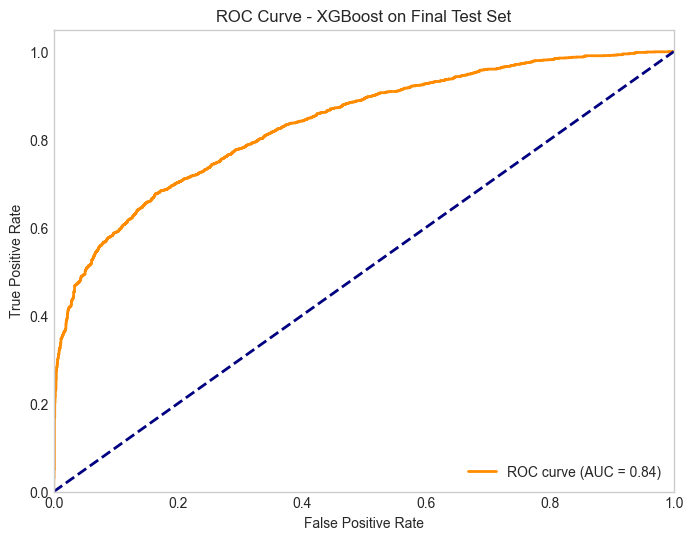

In [7]:
from sklearn.metrics import roc_curve, auc

# Lấy xác suất dự đoán cho lớp "1" (Present)
if hasattr(best_model, "predict_proba"):
    y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_pred_proba = best_model.decision_function(X_test_final)
else:
    raise ValueError("Mô hình không hỗ trợ tính xác suất hoặc decision function.")

# Tính FPR, TPR và thresholds
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba)

# Tính AUC
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Đường chéo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name} on Final Test Set')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Định nghĩa không gian tìm kiếm
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1.0, 1.5]
}


In [10]:
# Khởi tạo mô hình XGBoost cơ bản
xgb_model = XGBClassifier( eval_metric='logloss', random_state=42, n_jobs=-1)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Số lượng tổ hợp thử (tăng lên nếu có thời gian)
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


In [ ]:
random_search.fit(X_train_base, y_train_base)

# In ra kết quả tốt nhất
print("Best Hyperparameters:")
print(random_search.best_params_)

print(f"Best CV Accuracy: {random_search.best_score_:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
best_xgb = random_search.best_estimator_

# Huấn luyện lại trên toàn bộ Training Base
best_xgb.fit(X_train_base, y_train_base)

# Dự đoán & đánh giá
y_pred_final = best_xgb.predict(X_test_final)
print(classification_report(y_test_final, y_pred_final, target_names=['Absent', 'Present']))

# AUC
y_pred_proba = best_xgb.predict_proba(X_test_final)[:, 1]
fpr, tpr, _ = roc_curve(y_test_final, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned XGBoost')
plt.legend(loc="lower right")
plt.grid()
plt.show()
